## Chest X-Ray (Pneumonia):  

Using Network similar to VGG19

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
os.environ['XLA_FLAGS'] = '--xla_gpu_autotune_level=0'  # Prevent XLA from tuning MaxPooling

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
tf.config.optimizer.set_jit(False)

from tensorflow import keras
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, BatchNormalization, Dense, Flatten
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Conv2D
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2


from tensorflow.random import set_seed
set_seed(421)

import warnings
warnings.filterwarnings('ignore')

import sys
sys.stderr = open('err.txt', 'w')

2025-02-06 10:03:08.564061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 10:03:08.575003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 10:03:08.578233: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1738832590.459642    1658 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738832590.489352    1658 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have be

W0000 00:00:1738832988.935142    1787 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738832988.951583    1787 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738832988.963193    1787 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738832988.968396    1787 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738832988.973183    1787 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738832988.978460    1787 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738832988.982865    1787 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738832988.987942    1787 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1738837041.546304    1785 gp

In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:22:00.0, compute capability: 8.6


In [3]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [4]:
# We shuffle the original dataset and create val and test more balanced (0,6 train, 0.2 test, 0.2 val)
# folder structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------normal
#                  !-------------pneumonia

train_normal = glob.glob("./chest_xray_data/normal/*.jpeg")
train_pneumonia = glob.glob("./chest_xray_data/pneumonia/*.jpeg")
print('there are ',len(train_normal),'normal images and', len(train_pneumonia),'pneumonia images')
COUNT_PNEUMONIA = len(train_pneumonia)
COUNT_NORMAL = len(train_normal)

there are  1583 normal images and 4273 pneumonia images


In [5]:
all_list = [x for x in train_normal]
all_list.extend([x for x in train_pneumonia])

df_all = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), 
                      columns = ['class'])
df_all['image'] = [x for x in all_list]
print(df_all.shape)

(5856, 2)


In [6]:
train_df, dummy_df = train_test_split(df_all, test_size = 0.33, random_state = SEED, 
                                    stratify = df_all['class'])
test_df, val_df = train_test_split(dummy_df, test_size = 0.50, random_state = SEED, 
                                    stratify = dummy_df['class'])

print('train',train_df.shape, 'test', test_df.shape, 'val', val_df.shape)



train (3923, 2) test (966, 2) val (967, 2)


### Data Preparation 

In [31]:

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1/255.)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             dtype = 'float32',
                                             color_mode = 'rgb',
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            color_mode = 'rgb',
                                            dtype = 'float32',
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(test_df,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            color_mode = 'rgb',
                                            shuffle = False,
                                            dtype = 'float32')



Found 3923 validated image filenames belonging to 2 classes.
Found 967 validated image filenames belonging to 2 classes.
Found 966 validated image filenames belonging to 2 classes.


In [25]:
# to improve class balancing we calculate the weights to add to the training process

initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))


def compute_sample_weights(y_batch, class_weight_dict):
    """Assigns weights to a batch based on class occurrences."""
    y_batch = np.argmax(y_batch, axis=1)  # Convert one-hot to class indices
    return np.array([class_weights[label] for label in y_batch])

# Create a generator that yields sample weights
def train_generator_with_weights(generator):
    for X_batch, y_batch in generator:
        sample_weights = compute_sample_weights(y_batch, class_weights)
        yield X_batch, y_batch, sample_weights
        
ds_train_weighted = train_generator_with_weights(ds_train)

Initial bias: 0.99299
Weight for class 0: 1.85
Weight for class 1: 0.69


In [26]:
#Setting callbakcs

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 10,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [27]:
# Network similar to VGG19

model = Sequential()


model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4096)           │    51,384,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,786,961 (289.10 MB)

 Trainable params: 75,786,961 (289.10 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Compile Mode
model.compile(loss='binary_crossentropy',
              optimizer= Adam(learning_rate=0.0001),
              metrics=['acc'], jit_compile=False)

In [32]:
history = model.fit(ds_train,
          epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping_cb,checkpoint_cb]);

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 50s 370ms/step - acc: 0.7044 - loss: 0.6080 - val_acc: 0.7291 - val_loss: 0.5731
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 45s 363ms/step - acc: 0.8068 - loss: 0.3766 - val_acc: 0.9007 - val_loss: 0.2324
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 44s 360ms/step - acc: 0.8929 - loss: 0.2545 - val_acc: 0.9359 - val_loss: 0.1742
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 44s 357ms/step - acc: 0.9064 - loss: 0.2280 - val_acc: 0.9400 - val_loss: 0.1541
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 341ms/step - acc: 0.9356 - loss: 0.1735 - val_acc: 0.9349 - val_loss: 0.1649
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 44s 360ms/step - acc: 0.9342 - loss: 0.1783 - val_acc: 0.9483 - val_loss: 0.1435
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 47s 386ms/step - acc: 0.9300 - loss: 0.1816 - val_acc: 0.9586 - val_loss: 0.1235
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 46s 373ms/step - acc: 0.9446 - loss: 0.1505 - val_acc: 0.9555 - val_loss: 0.1448
Epoch 9/50
123/123 ━━━━━━━━━━━━━

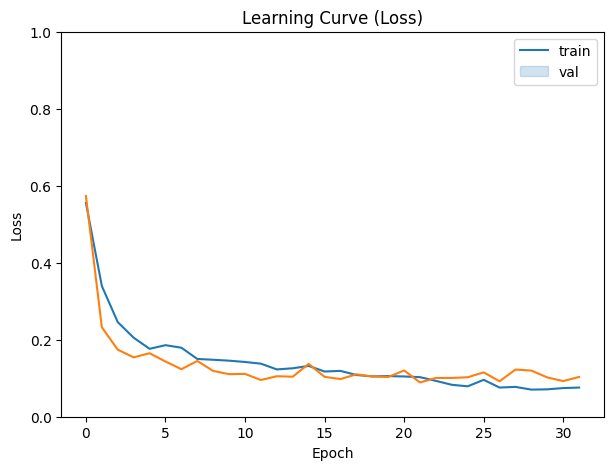

In [33]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc='best')
plt.show()

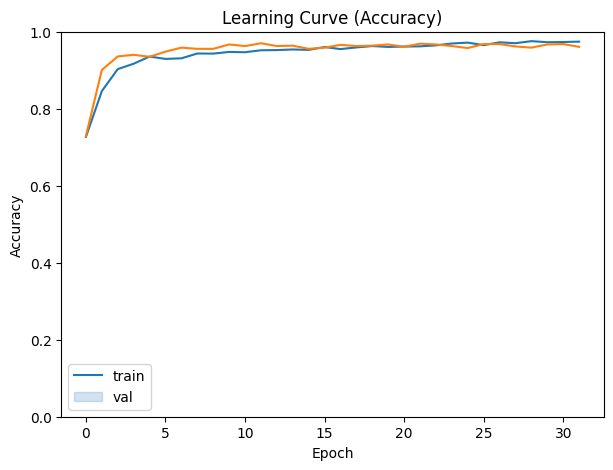

In [34]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(x = history.epoch, y = history.history['acc'])
sns.lineplot(x = history.epoch, y = history.history['val_acc'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [35]:
score = model.evaluate(ds_val, steps = int(len(val_df)/BATCH), verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.08872894942760468
Val accuracy: 0.9697916507720947


In [36]:
score = model.evaluate(ds_test, steps = int(len(test_df)), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08878864347934723
Test accuracy: 0.9606625437736511


### Result Performance Evaluation</a>  

In [37]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = test_df['class'].copy().map(num_label).astype('int')

In [38]:
ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [39]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9606625258799172


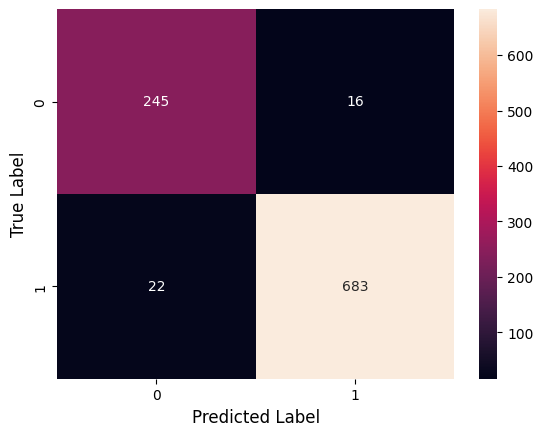

In [40]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [41]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       261
           1       0.98      0.97      0.97       705

    accuracy                           0.96       966
   macro avg       0.95      0.95      0.95       966
weighted avg       0.96      0.96      0.96       966



ROC_AUC:  0.9946088421510284


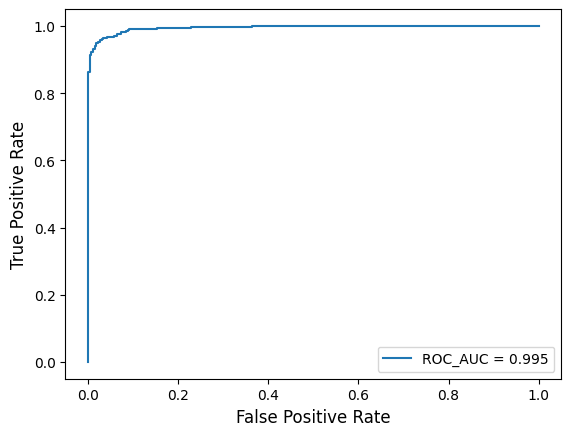

In [42]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

The recall was close to 100%. As we are in the medical field a discussion on the impact of false positives and false negatives is required. The impact on people's health will determine the applicability of a DL approach. Remember. Always Human Supervision!!!

In [43]:
import session_info
session_info.show(html=False)

-----
cv2                 4.11.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
pandas              2.2.3
seaborn             0.13.2
session_info        1.0.0
sklearn             1.5.2
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-02-06 11:17
